In [1]:
from osgeo import gdal,ogr,osr
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
file = "data/ang20180729t212542_rfl_v2r2_img"
hdr_file = f"{file}.hdr"

In [3]:
# Step 1: Open the hyperspectral image
img_file = file # Replace with your file path
img_open = gdal.Open(img_file)

# Step 2: Read the reflectance data (425 bands, 660 cols, 3647 rows)
bands = img_open.RasterCount
cols = img_open.RasterXSize
rows = img_open.RasterYSize

# Reading the reflectance data for each band (3D matrix of shape [bands, cols, rows])
#reflectance_data = np.zeros((bands, rows, cols), dtype=np.float32)  # Fixed shape to [bands, rows, cols]

reflectance_data = img_open.ReadAsArray()
reflectance_data = np.where(reflectance_data == -9999, np.nan, reflectance_data)
#for band in range(bands):
#    reflectance_data[band] = img_open.GetRasterBand(band + 1).ReadAsArray()

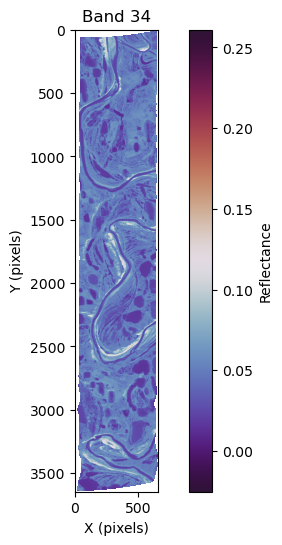

In [30]:
# Assuming `hyperspectral_data` is a 3D array (bands, height, width)
# Select the band you want to plot (e.g., band 1)
band_index = 34  # For the first band (adjust as needed)
band_data = reflectance_data[band_index - 1]  # Convert to 0-based index

# Plot the selected band
plt.figure(figsize=(8, 6))
plt.imshow(band_data, cmap='twilight_shifted')  # Use colormap 'gray' or any other as per preference
plt.colorbar(label='Reflectance')  # Add a color bar to indicate values
plt.title(f'Band {band_index}')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.show()

In [19]:
reflectance_data.shape

(425, 3647, 660)

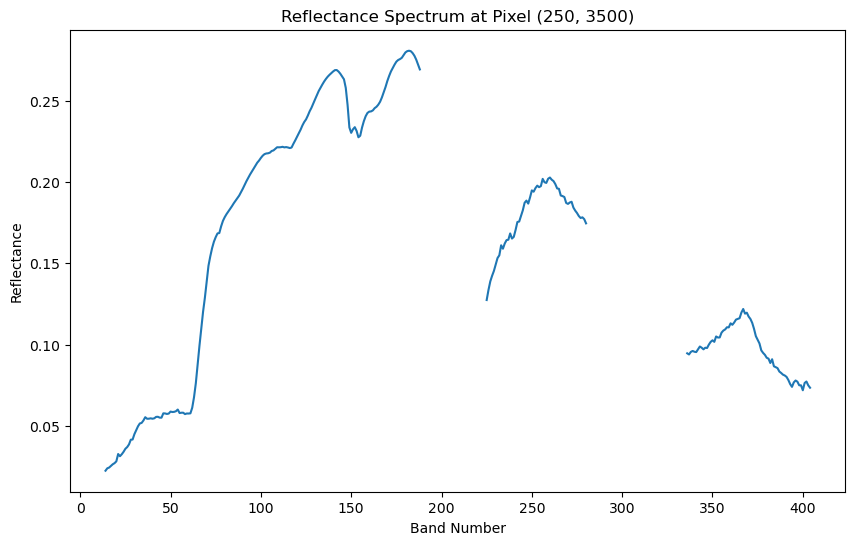

In [35]:
# define bands to cut out
bblist = np.ones((425,))
bblist[0:14] = 0
bblist[189:225] = 0
bblist[281:336] = 0
bblist[405:] = 0

# Define the pixel coordinates (row, column) you are interested in
pixel_x = 250  # X-coordinate (column)
pixel_y = 3500  # Y-coordinate (row)

# Extract reflectance data for the specified pixel across all bands
pixel_reflectance = reflectance_data[:, pixel_y, pixel_x]
pixel_reflectance[bblist == 0] = np.nan

# Plot the reflectance data
plt.figure(figsize=(10, 6))
plt.plot(pixel_reflectance, marker='none')
plt.title(f'Reflectance Spectrum at Pixel ({pixel_x}, {pixel_y})')
plt.xlabel('Band Number')
plt.ylabel('Reflectance')
plt.grid(False)
plt.show()

In [5]:
# Reshape to (num_pixels, num_bands)
pixels = reflectance_data.reshape((bands, -1)).T  # Shape: [num_pixels, num_bands]

In [20]:
pixels.shape

(2407020, 425)

In [6]:
# Step 4: Check for NaN values before attempting to remove
print(f"Shape of the original data: {pixels.shape}")
print(f"NaNs in the original data: {np.sum(np.isnan(pixels))}")

# Step 5: Remove rows (pixels) with any NaN values
pixels_clean = pixels[~np.isnan(pixels).any(axis=1)]  # Remove rows with any NaN values

# Step 6: Ensure no NaN values are left
print(f"Shape after removal: {pixels_clean.shape}")
print(f"NaNs after removal: {np.sum(np.isnan(pixels_clean))}")

Shape of the original data: (2407020, 425)
NaNs in the original data: 79099725
Shape after removal: (2220903, 425)
NaNs after removal: 0


In [7]:
# Normalize the data
pixels_normalized = (pixels_clean - np.min(pixels_clean, axis=0)) / (np.max(pixels_clean, axis=0) - np.min(pixels_clean, axis=0) + 1e-8)

In [8]:
# Split data into training and testing
train_data, test_data = train_test_split(pixels_normalized, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

In [9]:
print("Any NaN in train_tensor:", torch.isnan(train_tensor).any())
print("Any Inf in train_tensor:", torch.isinf(train_tensor).any())

Any NaN in train_tensor: tensor(False)
Any Inf in train_tensor: tensor(False)


In [11]:
# Define Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim),
            nn.Sigmoid(),  # To match normalized input
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

# Initialize model
input_dim = bands
latent_dim = 32  # Adjust this based on desired compression level
model = Autoencoder(input_dim=input_dim, latent_dim=latent_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
epochs = 50
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_tensor, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        reconstructed = model(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.size(0)
    train_loss /= len(train_tensor)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.6f}")

Epoch 1/50, Loss: 0.000228
Epoch 2/50, Loss: 0.000032
Epoch 3/50, Loss: 0.000021
Epoch 4/50, Loss: 0.000016
Epoch 5/50, Loss: 0.000015
Epoch 6/50, Loss: 0.000013
Epoch 7/50, Loss: 0.000012
Epoch 8/50, Loss: 0.000011
Epoch 9/50, Loss: 0.000010
Epoch 10/50, Loss: 0.000011
Epoch 11/50, Loss: 0.000009
Epoch 12/50, Loss: 0.000009
Epoch 13/50, Loss: 0.000008
Epoch 14/50, Loss: 0.000008
Epoch 15/50, Loss: 0.000008
Epoch 16/50, Loss: 0.000007
Epoch 17/50, Loss: 0.000007
Epoch 18/50, Loss: 0.000007
Epoch 19/50, Loss: 0.000007
Epoch 20/50, Loss: 0.000007
Epoch 21/50, Loss: 0.000007
Epoch 22/50, Loss: 0.000007
Epoch 23/50, Loss: 0.000007
Epoch 24/50, Loss: 0.000007
Epoch 25/50, Loss: 0.000006
Epoch 26/50, Loss: 0.000006
Epoch 27/50, Loss: 0.000006
Epoch 28/50, Loss: 0.000006
Epoch 29/50, Loss: 0.000006
Epoch 30/50, Loss: 0.000006
Epoch 31/50, Loss: 0.000006
Epoch 32/50, Loss: 0.000006
Epoch 33/50, Loss: 0.000006
Epoch 34/50, Loss: 0.000006
Epoch 35/50, Loss: 0.000006
Epoch 36/50, Loss: 0.000006
E

ValueError: cannot reshape array of size 71068896 into shape (3647,660,32)

In [13]:
# Evaluate the model
model.eval()
with torch.no_grad():
    reconstructed_test = model(test_tensor)
    test_loss = criterion(reconstructed_test, test_tensor).item()
    print(f"Test Loss: {test_loss:.6f}")

Test Loss: 0.000006


In [14]:
# Extract latent features
latent_features = model.encoder(torch.tensor(pixels_normalized, dtype=torch.float32)).detach().numpy()

In [17]:
# Reshape latent features for visualization or clustering
latent_image = latent_features.reshape((rows, cols, 29))

ValueError: cannot reshape array of size 71068896 into shape (3647,660,29)

In [ ]:
# Visualize one of the latent dimensions
plt.imshow(latent_image[:, :, 0], cmap="viridis")  # Visualize the first latent dimension
plt.colorbar()
plt.title("Latent Feature 1")
plt.show()